# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline



data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")


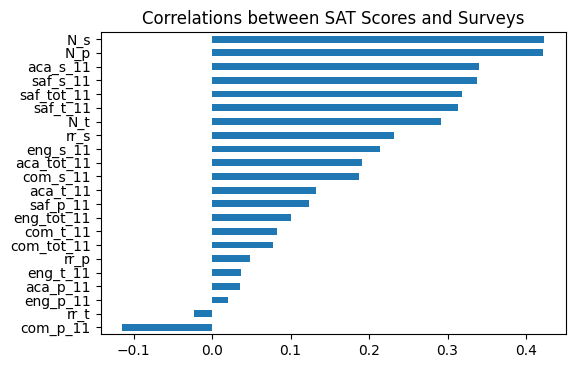

In [11]:
survey_corrs = correlations[survey_fields].sort_values()

survey_corrs.plot.barh()
plt.title('Correlations between SAT Scores and Surveys')
plt.show()

The correlations above show that the factors that are highly and positively correlated with SAT scores are the number of participants in the survey (N_s, N_t, and N_p), which measure how teachers and students perceive safety at school (saf_t_11, saf_s_11, and saf_tot_11), and student ratings of school academic standards (aca_s_11).
We'll dig into this relationship a bit more and try to figure out which schools have low safety scores

## Investigate safety scores:

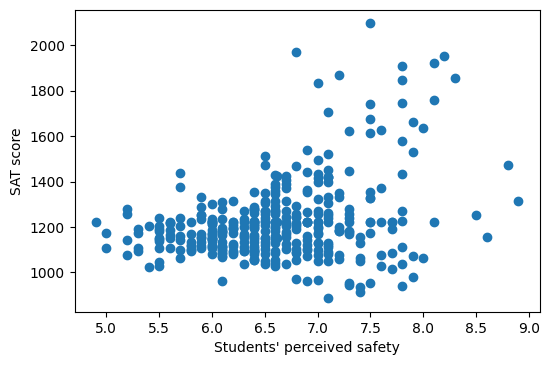

In [12]:
plt.scatter(x=combined['saf_s_11'], y=combined['sat_score'])
plt.xlabel("Students' perceived safety")
plt.ylabel('SAT score')
plt.show()

Observation on SAT Score vs Safety: 

There are appears to be a weak positive correlation between survey by students on safety and SAT scores. Despite this, there are few schools with both high safety scores and SAT scores and vice versa. There is however a cluster of schools in the middle with outliers where the safety is perceived high but low SAT score

### Borough Safety:

In [13]:
# Compute the average safety score for each borough.
boros = combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
print(boros)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

### Exploring Race and SAT Scores:


In [14]:
race_columns = ['white_per',
               'asian_per',
               'black_per',
               'hispanic_per']

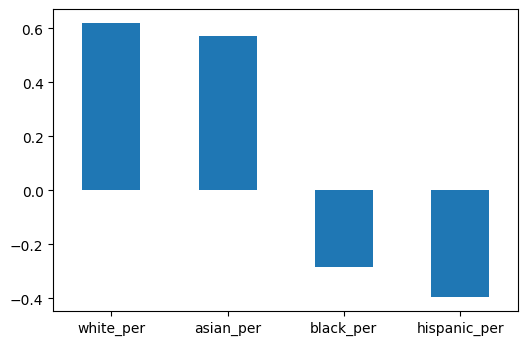

In [15]:
combined.corr()["sat_score"][race_columns].plot.bar(rot=0)

Higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score.

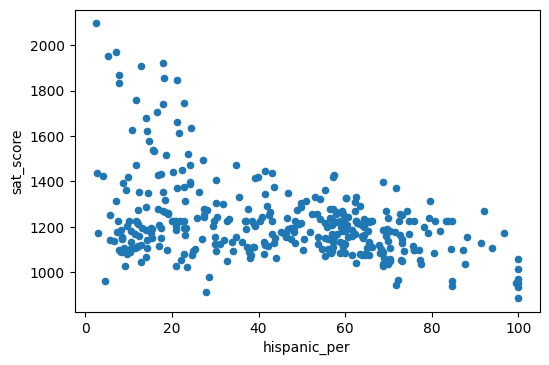

In [16]:
# Explore schools with low SAT scores and high values for hispanic_per.
# Make a scatter plot of hispanic_per vs. sat_score.
combined.plot.scatter("hispanic_per", "sat_score")


In [17]:
# Finding schools with a hispanic_per greater than 95%:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Most of the schools listed above are known for having lots of new immigrant and international students with English As Second Language so it would somewhat explain the high percentage of student with lower SAT scores.

In [18]:
# Find any schools with a hispanic_per less than 10% 
# and an average SAT score greater than 1800
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above specialized in science and technology thus have extra funding. They also very selective on which students they accept based on their entrance exams. It makes sense these students tend to do better on the SAT. 

## Exploring Gender and SAT Scores:

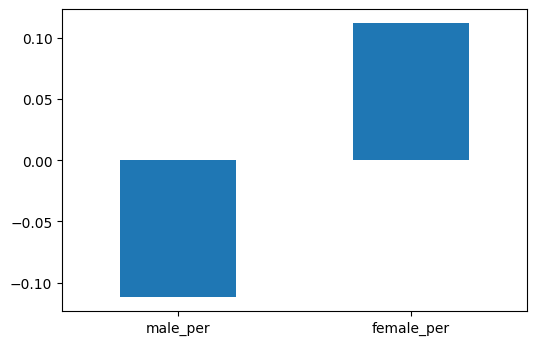

In [19]:
# Make a bar plot of the correlations between the columns above and sat_score
gender_columns = ['male_per',
                'female_per']
combined.corr()['sat_score'][gender_columns].plot.bar(rot=0)

Although netierh correlation is strong, we can see that female students do better in SAT test than male students in general. 

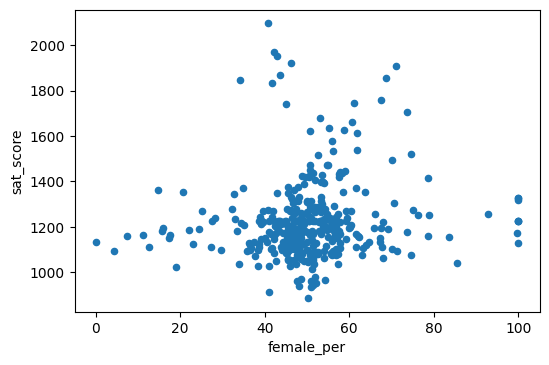

In [23]:
# Make a scatter plot of female_per vs. sat_score
combined.plot.scatter('female_per', 'sat_score')

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores (greater than 1,700). 
Let's find out which schools those are.

In [25]:
# Find the schools with female_per greater than 60% 
# and an average SAT score greater than 1700
print(combined[(combined['female_per']>60) & (combined['sat_score']>1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


After a quick wikipedia and google research, we can see that these are some really selective liberal arts that have high academic standards. 

## Exploring AP Scores vs. SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

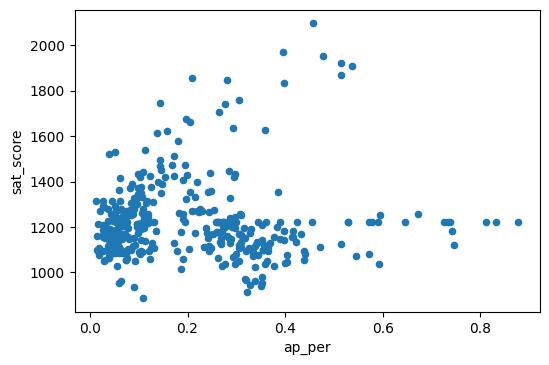

In [27]:
# Calculate the percentage of students in each school that took an AP exam.
# Divide the AP Test Takers column by the total_enrollment column.
# Assign the result to new column called ap_per
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

# Make a scatter plot of ap_per vs. sat_score.
combined.plot.scatter(x='ap_per', y='sat_score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. But it's not an extremely strong correlation.



## Exploring class size and SAT scores

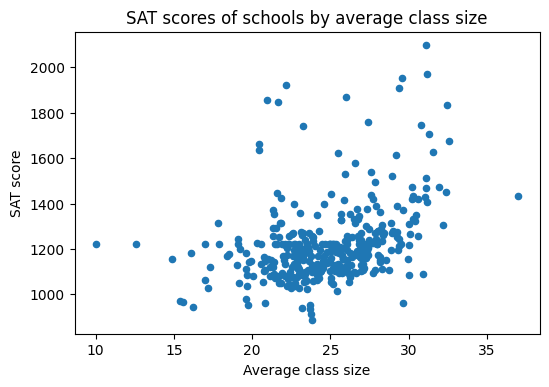

In [28]:
ax = combined.plot.scatter('AVERAGE CLASS SIZE','sat_score')
ax.set_xlabel('Average class size')
ax.set_ylabel('SAT score')
ax.set_title('SAT scores of schools by average class size')
plt.show()

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and average class size.

## Conclusion:
### After combining multiple datasets, we were able to somewhat find out what factors influence students the most on the SAT score. These are some of the conclusions:

- The schools that are selective in their admission process tend to have a better performance.
- The more the students and teachers percieve the school as safe, the better the SAT scores.
- Hispanic and black ethnic groups are very disadvantaged in comparison with white and Asian ethnic groups: they study in the less safe schools with poor academic standards.
- English As Sc